#### Mapping Bias in SafeGraph's Social Distancing dataset by Neighborhood Tabulated Area (NTA)

In [2]:
#reading in relevant libs
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import s3fs
import os
import time

In [41]:
# allow max rows and colums to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# make display wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [11]:
# read in GeoJSON
polygons = gpd.read_file(r'data/NTA.geojson')
polygons.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005019.048,047,Borough Park,39247.2278309,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...
1,QN51,52488277.5915,081,Murray Hill,33266.9048721,Queens,4,(POLYGON ((-73.80379022888246 40.7756101117924...
2,QN27,19726845.5925,081,East Elmhurst,19816.7121316,Queens,4,(POLYGON ((-73.86109724401859 40.7636644770877...
3,BK95,14522603.5915,047,Erasmus,18756.7018646,Brooklyn,3,(POLYGON ((-73.94826499590911 40.6386071897065...
4,QN07,22887772.8087,081,Hollis,20976.3355996,Queens,4,(POLYGON ((-73.75725671509139 40.7181386016625...


In [10]:
# read in bias csv
df = pd.read_csv('output_csv\dfnta_bias.csv')
df.head()

,month,orig_nta,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,orig_cbg,name,bias,bias_device,abs_bias,abs_bias_device
0,1,BK09,22887.0,24168.0,2236.0,1400.0,1770.0,1224.0,17538.0,694.571429,1510.142857,3.604700e+11,Brooklyn Heights Cobble Hill,-0.013102,-0.012343,0.013102,0.012343
1,1,BK17,64518.0,65631.0,12973.0,4254.0,6021.0,1440.0,40943.0,4262.142857,7323.000000,3.604706e+11,Sheepshead Bay Gerritsen Beach Manhattan Beach,0.012801,0.046649,0.012801,0.046649
2,1,BK19,35547.0,34431.0,4745.0,234.0,3673.0,1255.0,24524.0,2285.142857,4202.000000,3.604704e+11,Brighton Beach,0.012125,0.026131,0.012125,0.026131
3,1,BK21,31965.0,32259.0,2808.0,9430.0,8992.0,789.0,10240.0,1866.142857,3877.571429,3.604703e+11,Seagate Coney Island,0.010469,0.015209,0.010469,0.015209
4,1,BK23,17750.0,16774.0,139.0,280.0,660.0,170.0,15525.0,1014.714286,1651.000000,3.604704e+11,West Brighton,-0.000041,0.009405,0.000041,0.009405


In [202]:
# merging our geojson with dataframe that contains bias
geo_nta = pd.merge(polygons, df, left_on = 'ntacode', right_on = 'orig_nta')
geo_nta = geo_nta.drop(columns = ['ntaname','orig_nta','orig_cbg']) # dropping repetitive and unnecessary columns
geo_nta.head()

,ntacode,shape_area,county_fips,shape_leng,boro_name,boro_code,geometry,month,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,name,bias,bias_device,abs_bias,abs_bias_device
0,BK88,54005019.048,047,39247.2278309,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...,1,102272.857143,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,1985.428571,3869.285714,Borough Park,-0.093631,-0.084741,0.093631,0.084741
1,BK88,54005019.048,047,39247.2278309,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...,2,105286.857143,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,2106.142857,4366.285714,Borough Park,-0.086168,-0.080668,0.086168,0.080668
2,BK88,54005019.048,047,39247.2278309,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...,3,103256.571429,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,2162.857143,4563.285714,Borough Park,-0.083210,-0.078754,0.083210,0.078754
3,BK88,54005019.048,047,39247.2278309,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...,4,101956.142857,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,2002.285714,4794.857143,Borough Park,-0.079733,-0.084172,0.079733,0.084172
4,BK88,54005019.048,047,39247.2278309,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...,5,99939.857143,102494.0,13253.0,1059.0,8776.0,808.0,78598.0,1985.285714,4669.000000,Borough Park,-0.081622,-0.084746,0.081622,0.084746


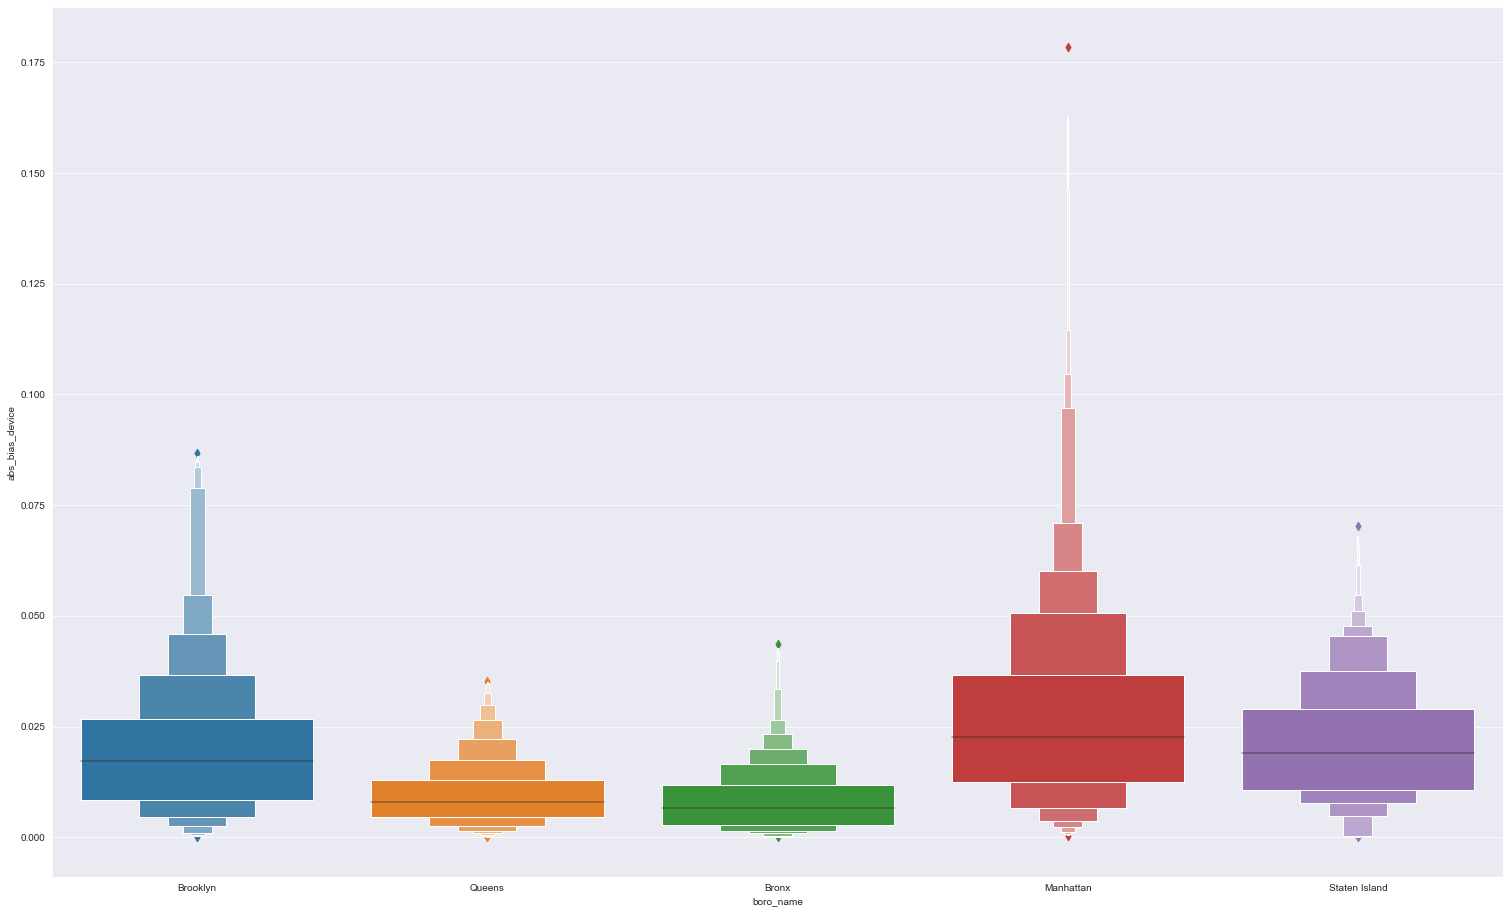

In [57]:
# quick view of bias averages for each neighborhood by borough
sns.set_style("darkgrid")
sns.boxenplot(x = "boro_name", y = "abs_bias_device",data = geo_nta)

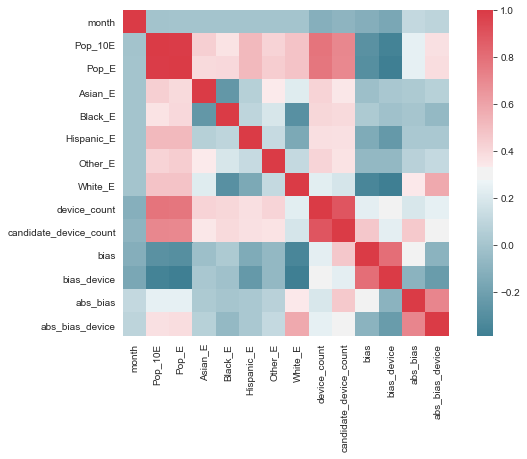

In [70]:
# correlation heat map to quickly view any similarities/disparities in data
f, ax = plt.subplots(figsize=(10, 6))
corr = geo_nta.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [71]:
# Check statistics as base for Bins
q_up = geo_nta['bias_device'].quantile(q = 0.75) # 75th percentile
med = geo_nta['bias_device'].quantile(q = 0.5) # 50th percentile (median)
q_low = geo_nta['bias_device'].quantile(q = 0.25) # 25th percentile
q_95 = geo_nta['bias_device'].quantile(q = 0.95) # want the highest counts to have weight as well
print(' Q1:',q_low,
     '\n Medain:',med,
     '\n Q3:', q_up,
     '\n Upper 5%:', q_95)

 Q1: -0.010938048227015875 
 Medain: 0.0028985639503186396 
 Q3: 0.012178877357756027 
 Upper 5%: 0.030736448827265644


In [76]:
geo_nta['bias_device'].describe()

count    1550.000000
mean       -0.000011
std         0.022020
min        -0.107535
25%        -0.010938
50%         0.002899
75%         0.012179
max         0.178515
Name: bias_device, dtype: float64

#### Setting bins in new column for map clarity
##### this is not needed in the actual map output

In [134]:
bias_data = geo_nta["bias_device"]
cut_bins = [-0.15, -0.010, -0.005, -.0025, 0.0025, 0.005, 0.015, 0.2] #setting ranges for the map
geo_nta['device_bins'] = pd.cut(np.array(bias_data), bins = cut_bins)

In [164]:
# viewing specific month
geo_may = geo_nta[geo_nta['month'] == 8]
geo_may.describe()

,month,Pop_10E,Pop_E,Asian_E,Black_E,Hispanic_E,Other_E,White_E,device_count,candidate_device_count,bias,bias_device,abs_bias,abs_bias_device
count,194.0,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,8.0,41893.157585,43524.293814,6017.634021,9551.829897,12665.654639,1299.845361,13989.329897,1890.995582,3836.270250,-0.006828,-0.000629,0.019750,0.018643
std,0.0,21985.420938,22661.508943,7738.325583,13759.673169,12023.014127,1643.726944,14747.159345,983.226819,2548.445028,0.034775,0.027055,0.029395,0.019571
min,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.142857,14.857143,-0.104058,-0.094626,0.000121,0.000308
25%,8.0,26160.000000,26941.500000,1128.250000,1080.750000,3828.250000,584.250000,2424.000000,1284.428571,2469.071429,-0.020259,-0.015096,0.005779,0.006381
50%,8.0,37185.000000,39313.000000,2970.500000,3663.000000,8232.000000,947.500000,10143.000000,1675.857143,3447.000000,-0.007457,0.000932,0.012131,0.013207
75%,8.0,53968.500000,54666.750000,8432.250000,12434.000000,18464.250000,1536.750000,19390.000000,2197.714286,4699.535714,0.004134,0.010792,0.026737,0.024811
max,8.0,131276.285714,132455.000000,50289.000000,74112.000000,66285.000000,18065.000000,89144.000000,7164.142857,27729.142857,0.353166,0.178515,0.353166,0.178515


In [317]:
# month dictionary to iterate each map
month_dict = {'1':'January',
              '2':'February',
              '3':'March',
              '4':'April',
              '5':'May',
              '6':'June',
              '7':'July',
              '8':'August'}
ticks = ['20%', '15%', '10%', '5%', '0', '-5%', '-10%', '-15%', '-20%']
# making a function for each map by month
def monthly_maps(gdf, month):
    fig, ax = plt.subplots(1, figsize = (20,16))
    ax.axis('off')
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-.2, vmax=.2)) # normalize each choropleth map to be same
   # plt.colorbar.set_ticklabels(['20%', '15%', '10%', '5%', '0', '-5%', '-10%', '-15%', '-20%'])
    divnorm = mpl.colors.TwoSlopeNorm(vmin= -0.025, vcenter = 0,vmax = 0.025) # within a 95% accuracy one way or other
    sm.set_array([])
    gdf.plot(column = 'bias_device', cmap = 'RdBu', edgecolor="face", norm = divnorm, linewidth=0.4, ax = ax)
    fig.colorbar(sm, fraction = 0.02, norm = divnorm)
    ax.set_title(f'NTA-level Sampling Bias, First week of {mn} 2020', color = 'k',  fontsize = 15)
    ## add annotation, if necessary
   # ax.annotate('Credit to SafeGraph Social Distancing-v2 dataset\nData gathered from the Census Block Group level',
   #             xy = (0.6,.05), xycoords = 'figure fraction', fontsize = 11, color = 'k')
    plt.savefig(f'Maps/NTA_bias{mn}.jpg', dpi = 400) # saving each scatter plot by month

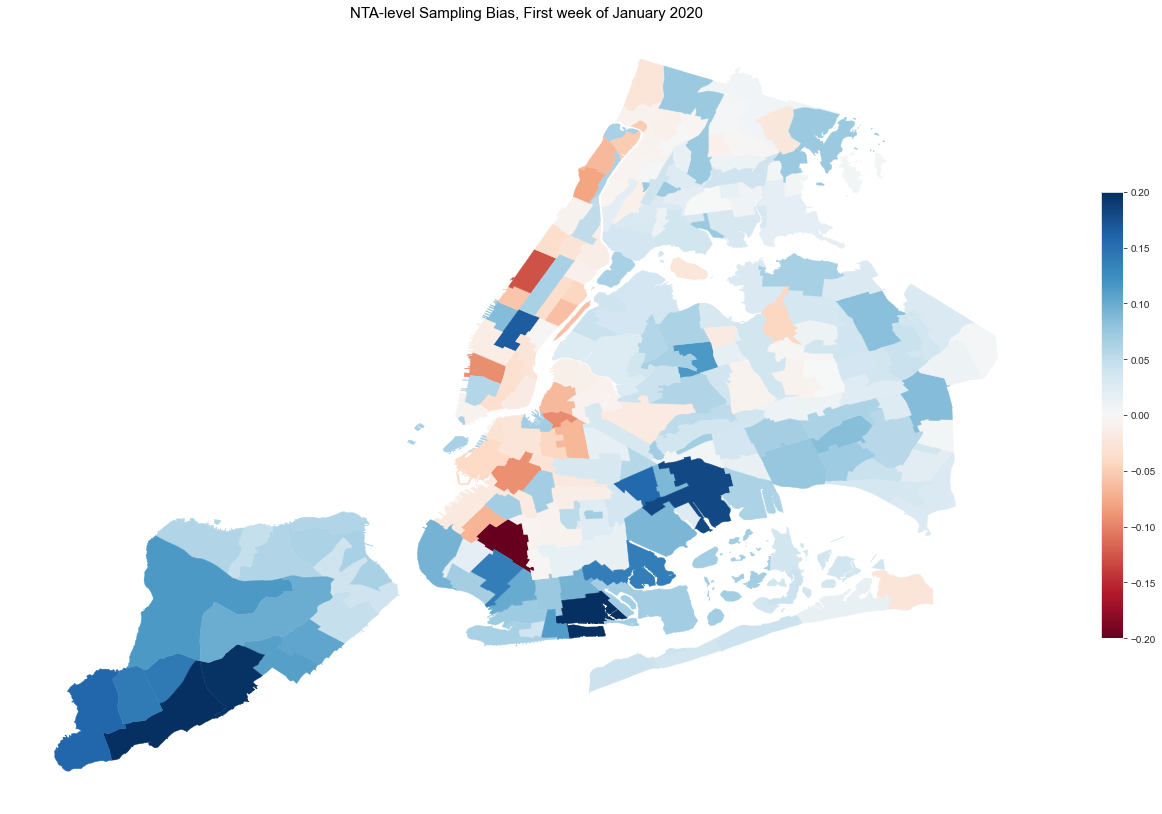

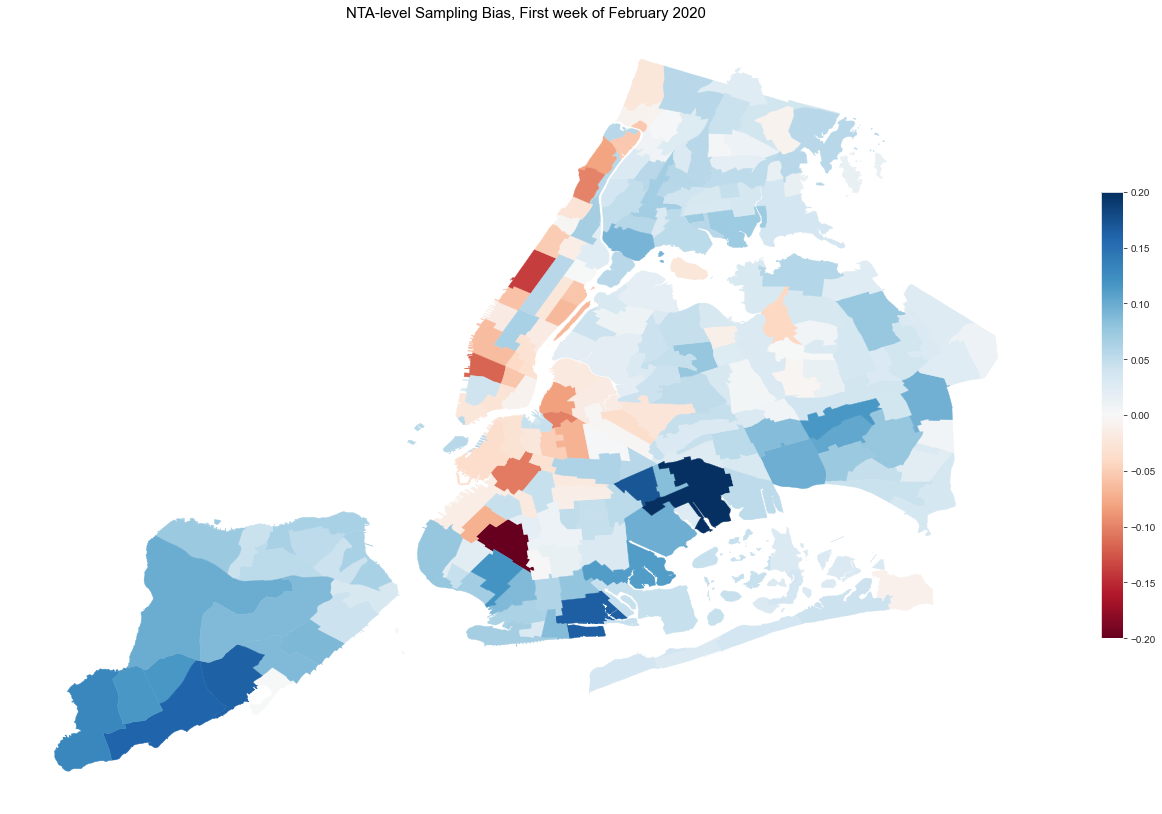

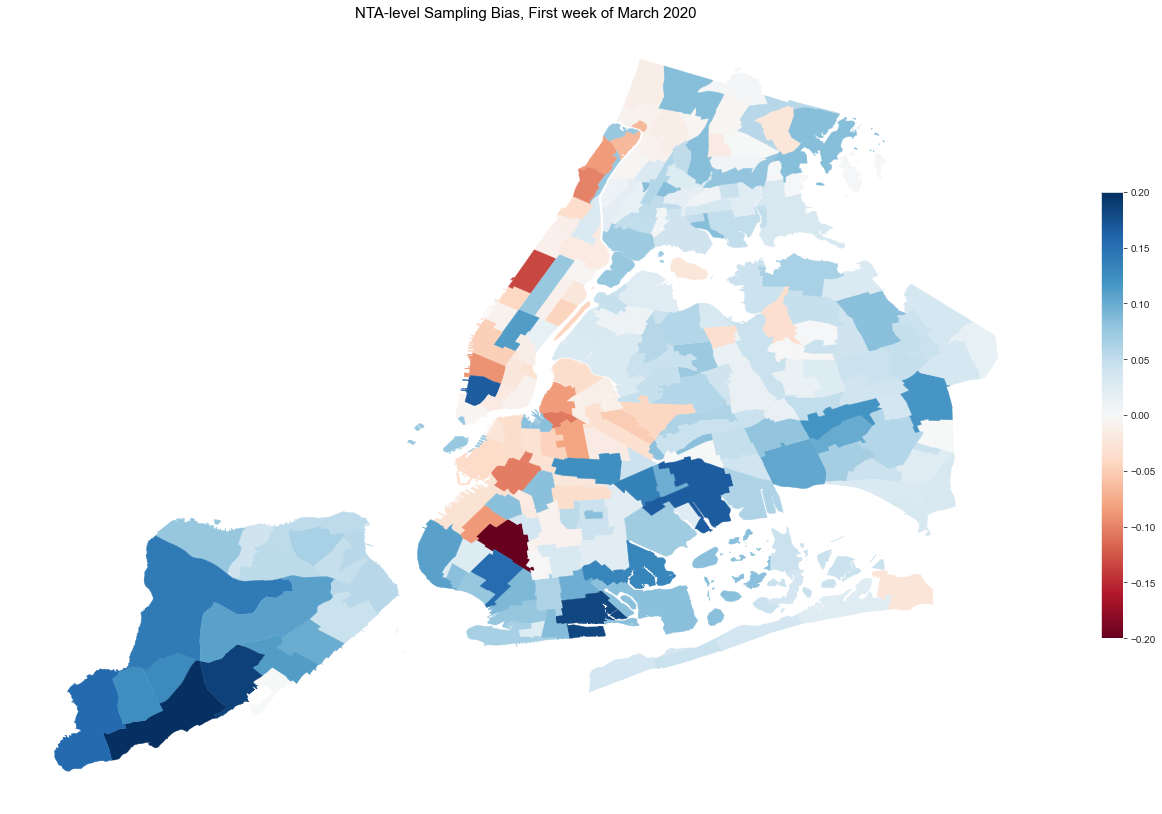

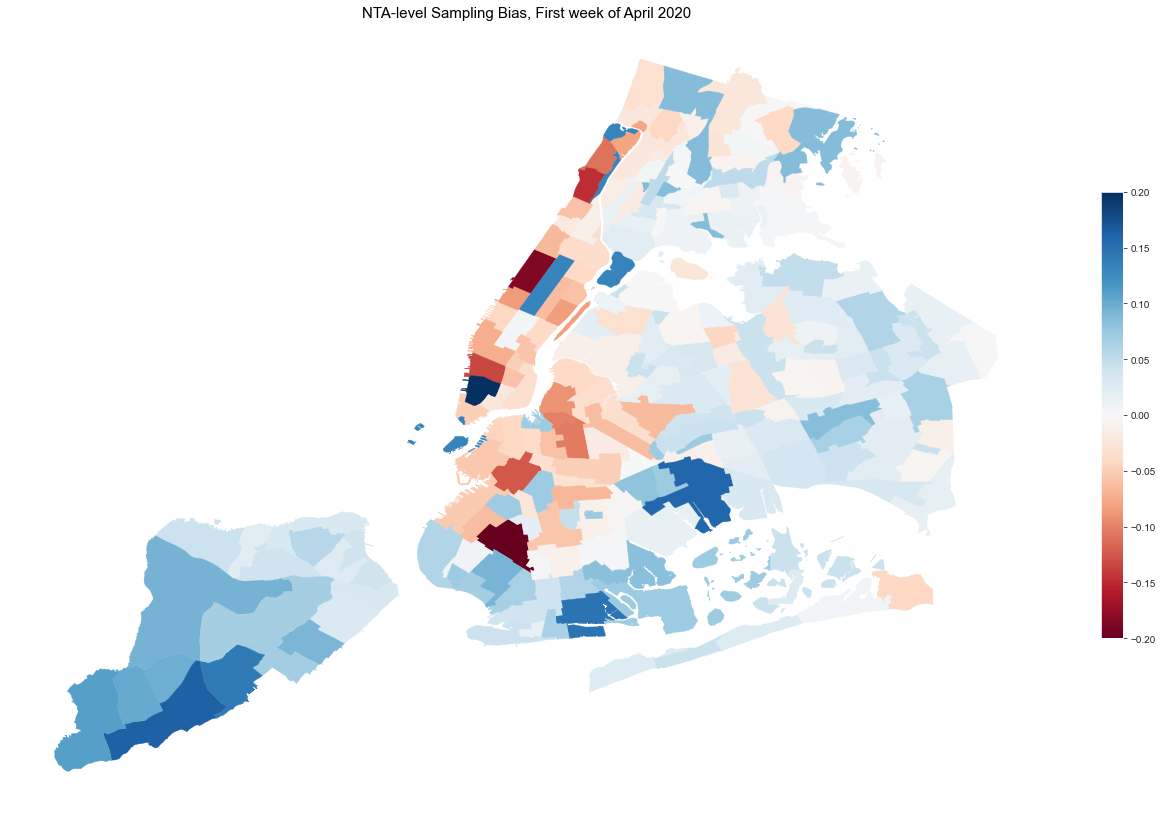

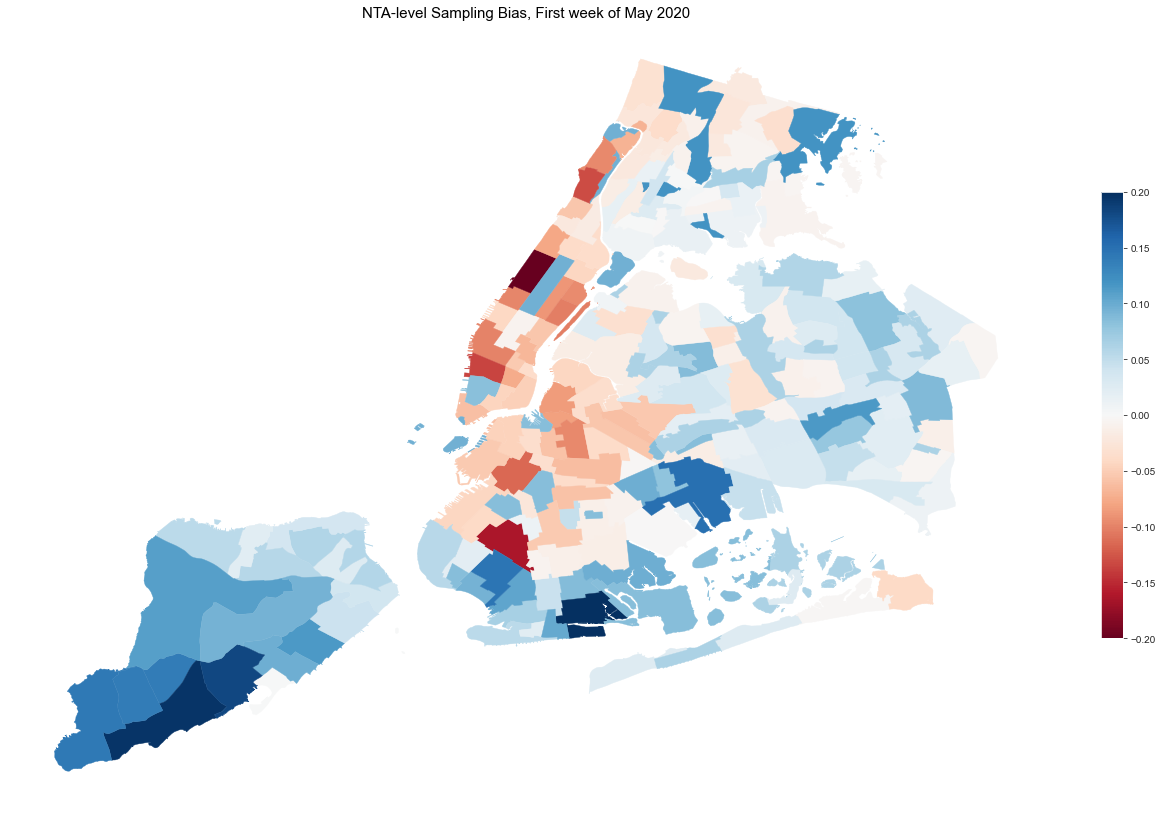

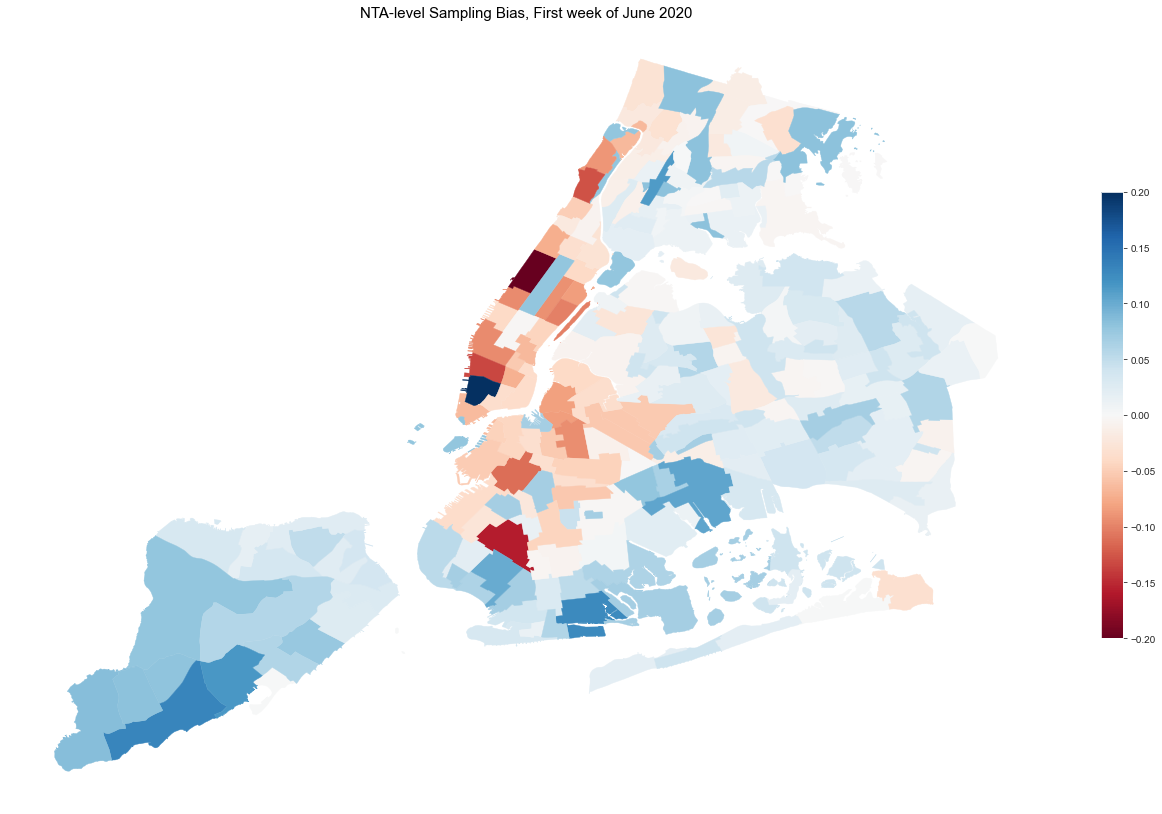

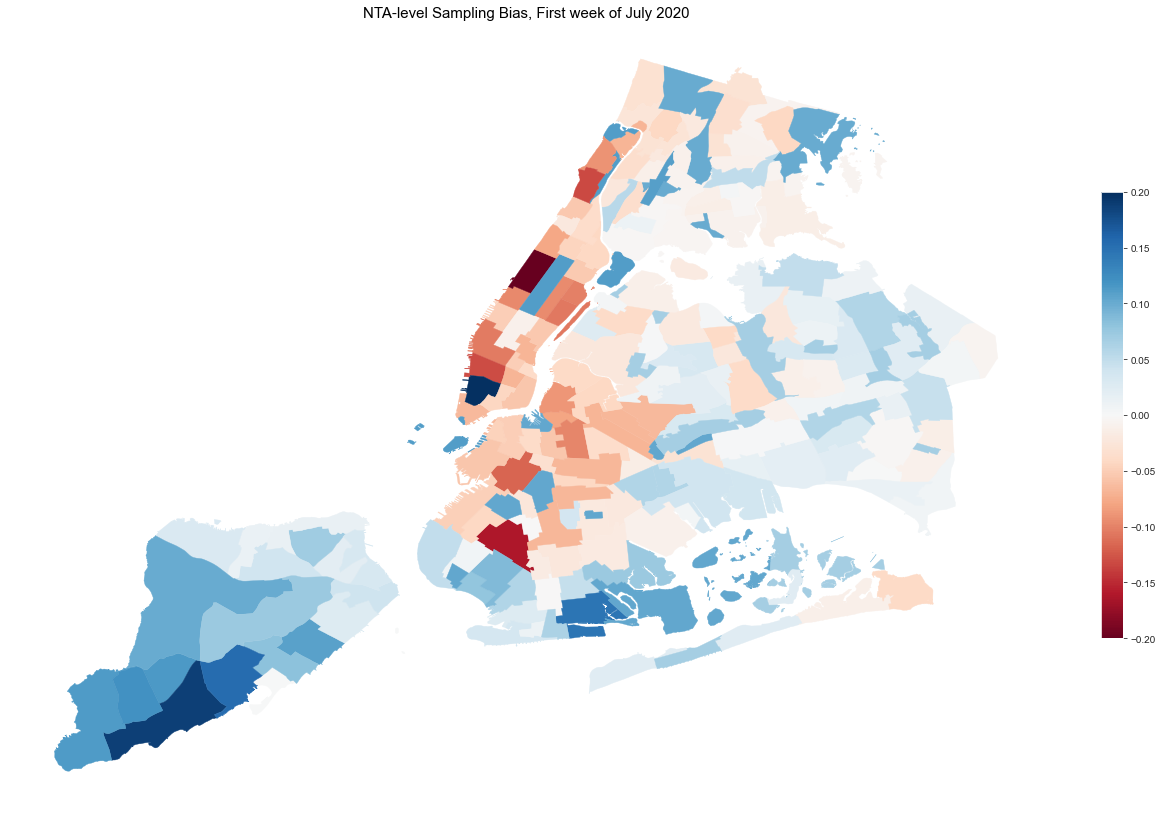

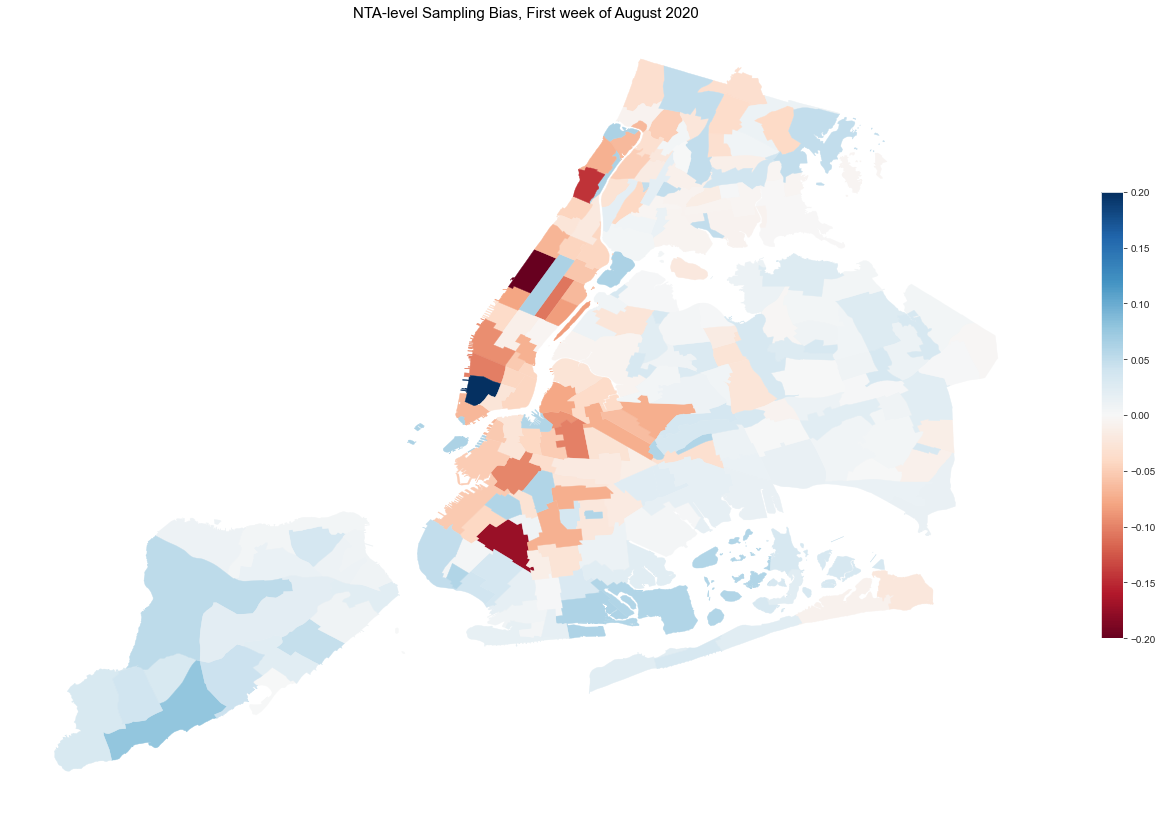

In [318]:
for m, mn in month_dict.items():
    gdf = geo_nta[geo_nta['month'].isin([m])]
    monthly_maps(gdf, mn)